
# Importing all required libraries



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import datetime as dt
import calendar,warnings,itertools,matplotlib,keras,shutil
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.datasets import load_iris,make_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from keras import Sequential
from keras.layers import Dense
from IPython.core import display as ICD

warnings.filterwarnings('ignore') 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importing Dataset using pandas

In [2]:
df = pd.read_csv("./DataCoSupplyChainDataset.csv", header= 0, encoding= 'unicode_escape')
df.head(10)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class
5,TRANSFER,6,4,18.580000,294.980011,Shipping canceled,0,73,Sporting Goods,Tonawanda,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/19/2018 11:03,Standard Class
6,DEBIT,2,1,95.180000,288.420013,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 10:42,First Class
7,TRANSFER,2,1,68.430000,285.140015,Late delivery,1,73,Sporting Goods,Miami,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 10:21,First Class
8,CASH,3,2,133.720001,278.589996,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 10:00,Second Class
9,CASH,2,1,132.149994,275.309998,Late delivery,1,73,Sporting Goods,San Ramon,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 9:39,First Class


# Data Cleaning

In [3]:
df.shape

(180519, 53)

In [4]:
df.apply(lambda x: sum(x.isnull()))

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [5]:
df['Customer Full Name'] = df['Customer Fname'].astype(str)+ df['Customer Lname'].astype(str)

Some columns of the dataset has been dropped.

In [6]:
data = df.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape

(180519, 42)

Missing values are replaced with zeros.

In [7]:
data['Customer Zipcode'] = data['Customer Zipcode'].fillna(0)

# **Data Correlation - Heatmap**

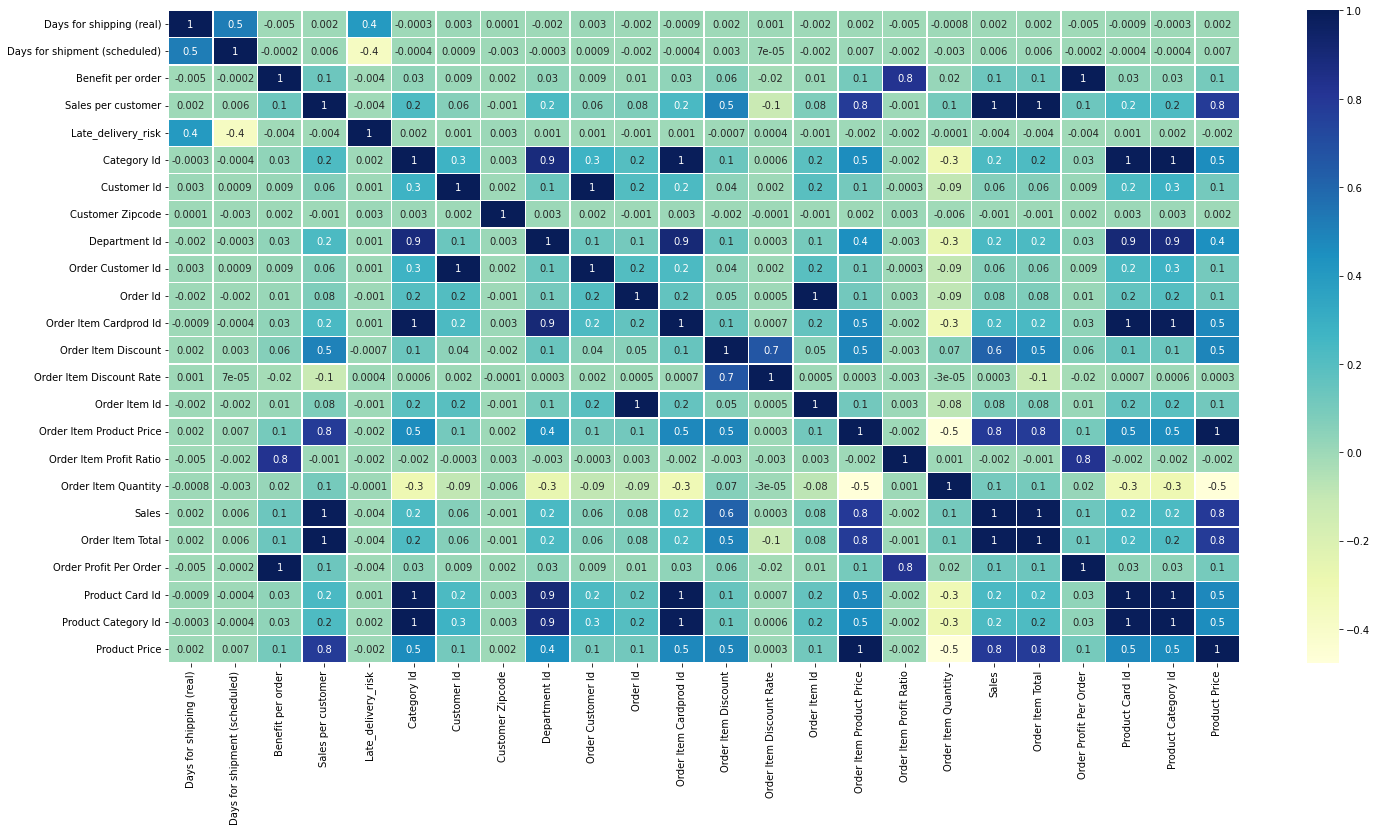

In [8]:
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap="YlGnBu")

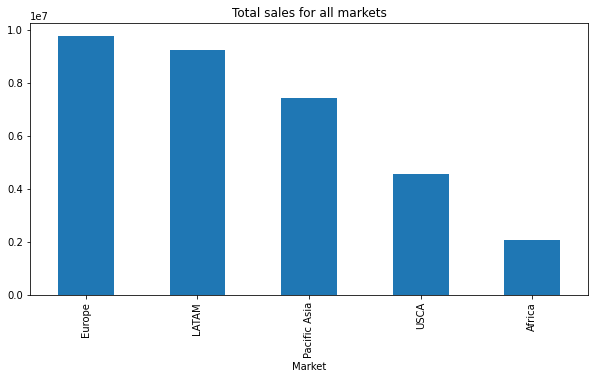

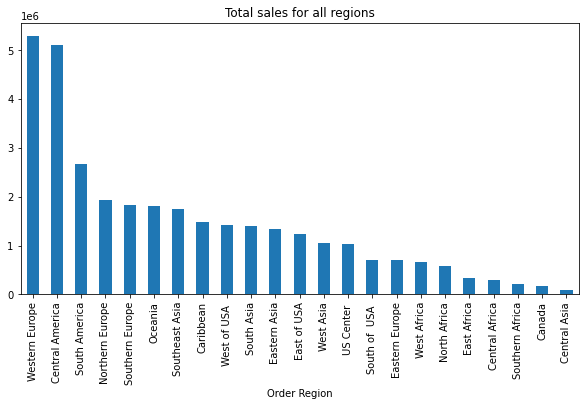

In [9]:
market = data.groupby('Market') 
region = data.groupby('Order Region')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(10,5), title="Total sales for all markets")
plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(10,5), title="Total sales for all regions")
plt.show()

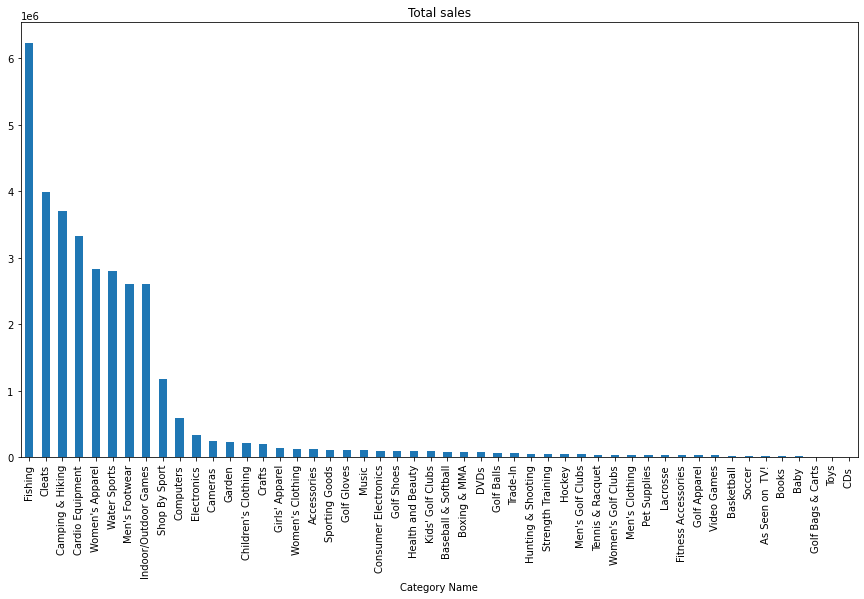

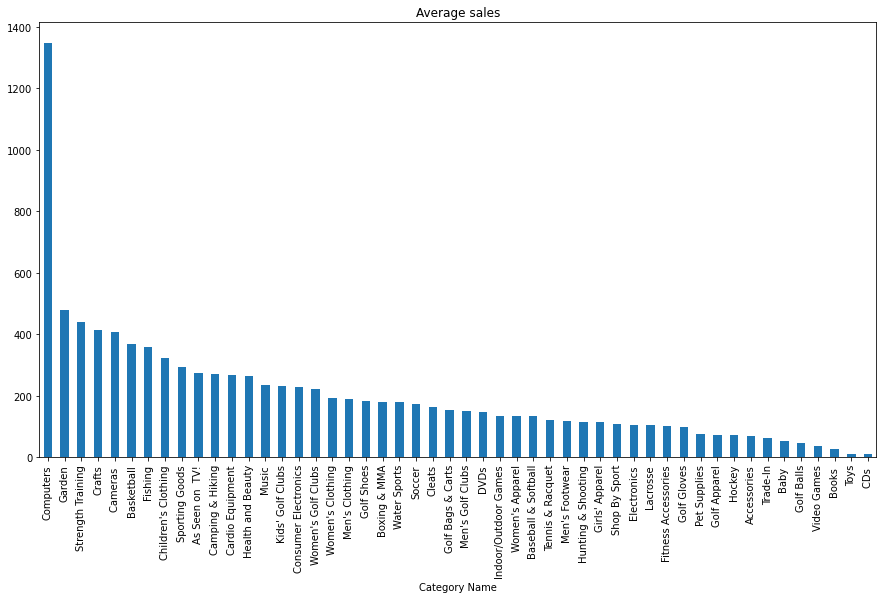

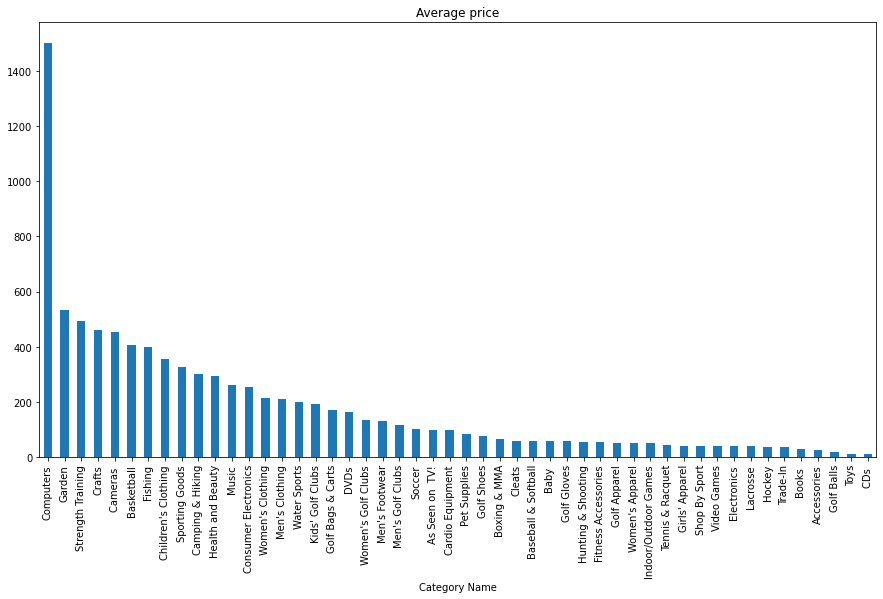

In [10]:
category = data.groupby('Category Name')
plt.figure(1)
# Total sales sum
category['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(15,8), title="Total sales")
# Avg sales
plt.figure(2)
category['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(15,8), title="Average sales")
plt.figure(3)
# Avg prices
category['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(15,8), title="Average price")

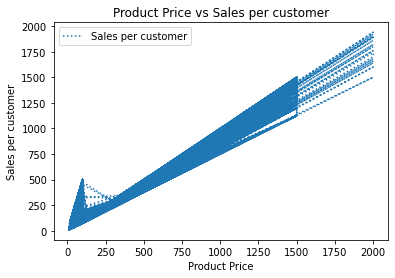

In [11]:
data.plot(x='Product Price', y='Sales per customer',linestyle='dotted',
      markerfacecolor='blue', markersize=12) 
plt.title('Product Price vs Sales per customer') #title
plt.xlabel('Product Price')  # X-axis title
plt.ylabel('Sales per customer') # Y=axis title
plt.show()

In [12]:
data['order_year']= pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).weekday
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
data['order_month_year'] = pd.to_datetime(data['order date (DateOrders)']).dt.to_period('M')

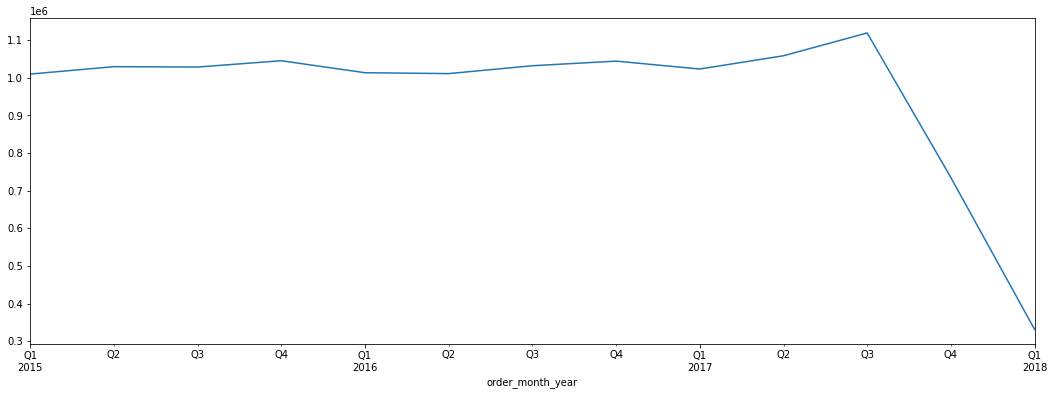

In [13]:
quater= data.groupby('order_month_year')
quartersales=quater['Sales'].sum().resample('Q').mean().plot(figsize=(18,6))

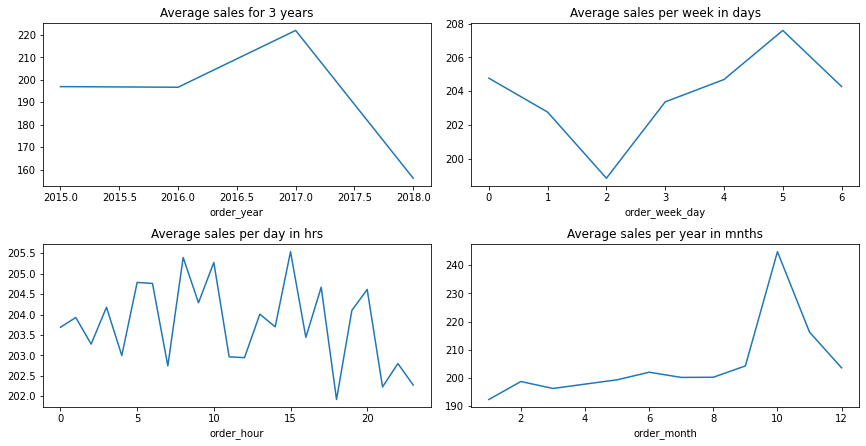

In [14]:
plt.figure(figsize=(12,12))
plt.subplot(4, 2, 1)
quater= data.groupby('order_year')
quater['Sales'].mean().plot(figsize=(12,12),title='Average sales for 3 years')
plt.subplot(4, 2, 2)
days=data.groupby("order_week_day")
days['Sales'].mean().plot(figsize=(12,12),title='Average sales per week in days')
plt.subplot(4, 2, 3)
hrs=data.groupby("order_hour")
hrs['Sales'].mean().plot(figsize=(12,12),title='Average sales per day in hrs')
plt.subplot(4, 2, 4)
mnth=data.groupby("order_month")
mnth['Sales'].mean().plot(figsize=(12,12),title='Average sales per year in mnths')
plt.tight_layout()
plt.show()

In [15]:
data['Type'].unique()

array(['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT'], dtype=object)

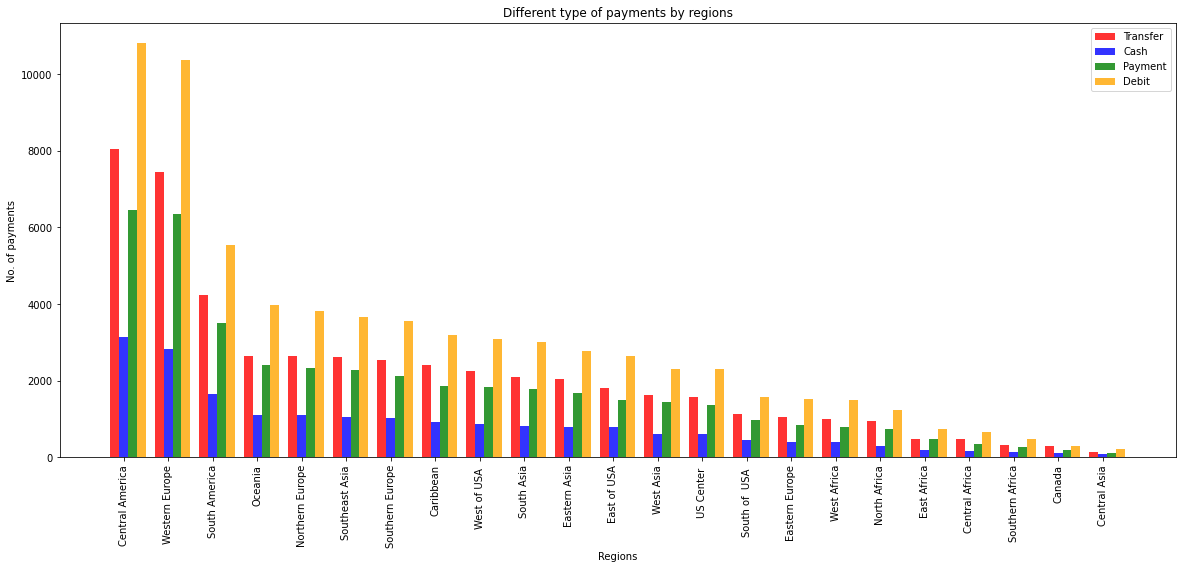

In [16]:
transfer = data[(data['Type'] == 'TRANSFER')]
cash = data[(data['Type'] == 'CASH')]
payment = data[(data['Type'] == 'PAYMENT')]
debit = data[(data['Type'] == 'DEBIT')]
transfer_count = transfer['Order Region'].value_counts()
cash_count = cash['Order Region'].value_counts()
payment_count = payment['Order Region'].value_counts()
debit_count = debit['Order Region'].value_counts()
names = data['Order Region'].value_counts().keys()
n_groups = names.shape[0]
fig,ax = plt.subplots(figsize=(20,8))
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8
transfer_plt = plt.bar(index, transfer_count, bar_width, alpha=opacity, color='red', label='Transfer')
cash_plt = plt.bar(index+bar_width, cash_count, bar_width, alpha=opacity, color='blue', label='Cash')
payment_plt = plt.bar(index+bar_width+bar_width, payment_count, bar_width, alpha=opacity, color='green', label='Payment')
debit_plt = plt.bar(index+bar_width+bar_width+bar_width, debit_count, bar_width, alpha=opacity, color='orange', label='Debit')
plt.xlabel('Regions')
plt.ylabel('No. of payments')
plt.title('Different type of payments by regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
# plt.tight_layout()
plt.show()

Total loss of revenue -3883547.345768667


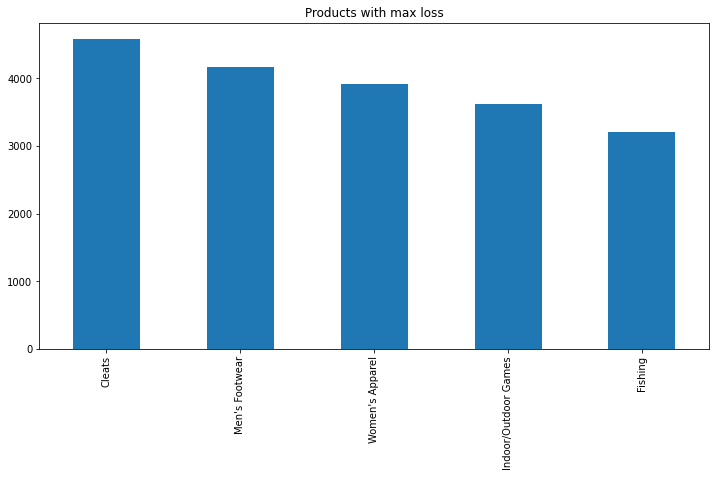

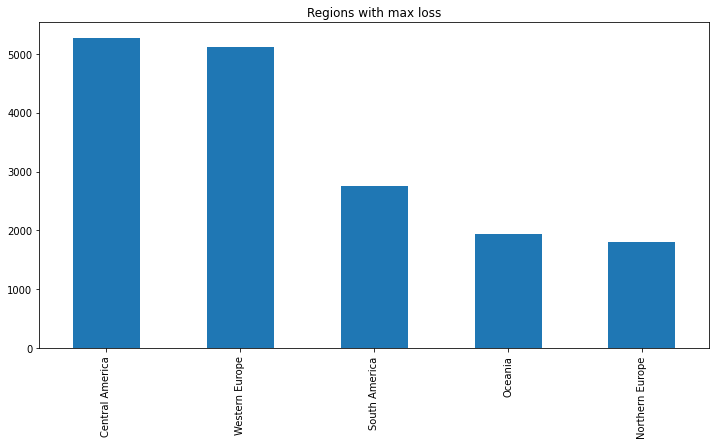

In [17]:
loss_of_revenue = data[(data['Benefit per order']<0)]
#top 5 products with max loss
plt.figure(1)
loss_of_revenue['Category Name'].value_counts().nlargest(5).plot.bar(figsize=(12,6), title="Products with max loss")
plt.figure(2)
loss_of_revenue['Order Region'].value_counts().nlargest(5).plot.bar(figsize=(12,6), title="Regions with max loss")
#Sum of total sales which are lost
print('Total loss of revenue',loss_of_revenue['Benefit per order'].sum())

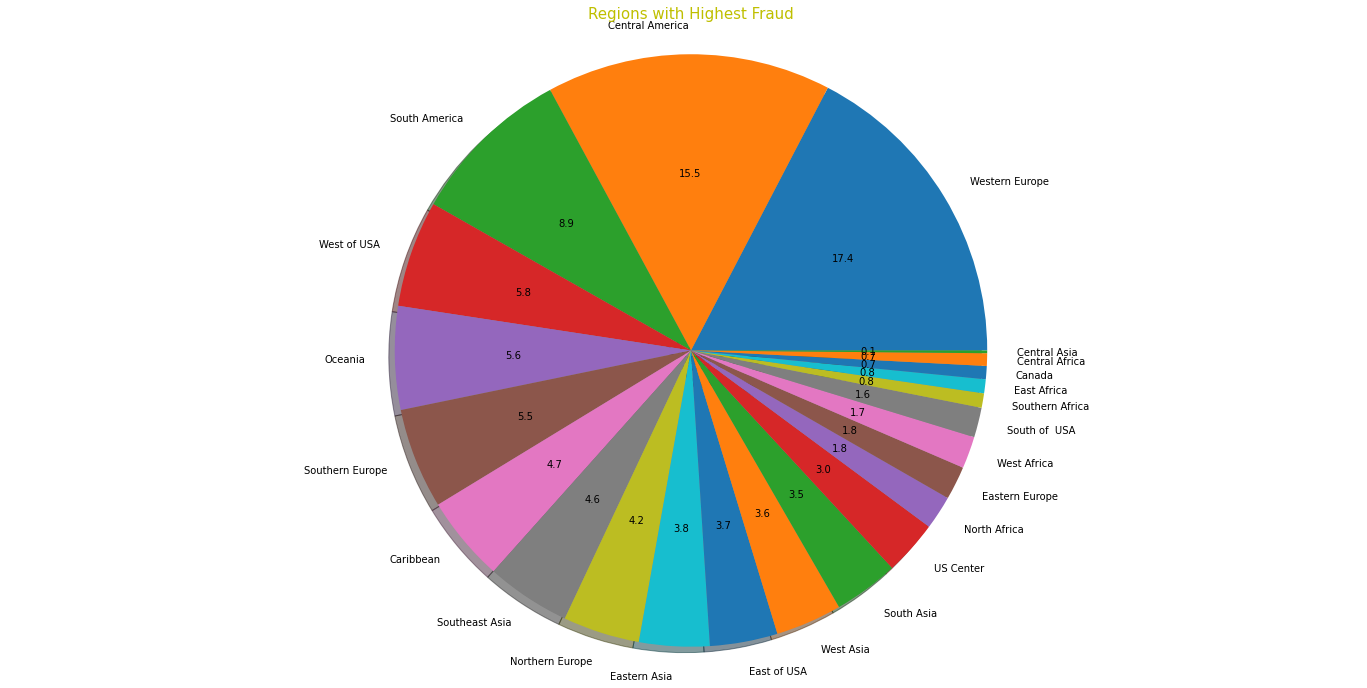

In [19]:
high_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') & (data['Type'] == 'TRANSFER')]#separating orders with suspected fraud
#Plotting pie chart with respect to order region
fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12), 
                                                  autopct='%.1f',shadow=True,)
plt.title("Regions with Highest Fraud",size=15,color='y') # Plotting title
plt.ylabel(" ")
fraud.axis('equal') 
plt.show()

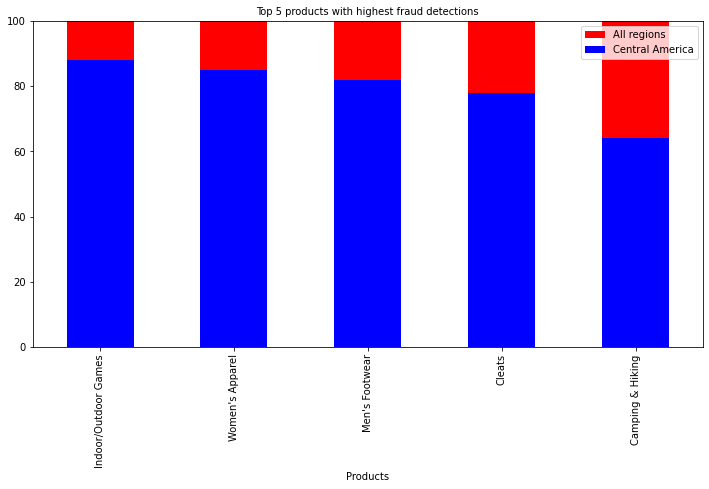

In [20]:
overall_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] # 
central_america_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Central America')]
#top 5 most suspected fraud department in all regions
overall_fraud=overall_fraud['Category Name'].value_counts().nlargest(5).plot.bar(figsize=(12,6), title="Fraud Category",color='red')
#top 5 most suspected fraud department in Central America
central_america_fraud=central_america_fraud['Category Name'].value_counts().nlargest(5).plot.bar(figsize=(12,6), title="Products",color='blue')
plt.legend(["All regions", "Central America"])
plt.title("Top 5 products with highest fraud detections", size=10)
plt.xlabel("Products", size=10)
plt.ylim(0,100)
plt.show()

# Customer Segmentation

RFM analysis

Recency - time since last cust order

Frequency - no. of times a customer ordered

Monetary - how much a customer has spent purchasing items

In [26]:
#calculate total price for order
data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Total']


In [27]:
#last order time
data['order date (DateOrders)'].max()

'9/9/2017 9:50'

In [28]:
curr_date = dt.datetime(2017,9,10)
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])

In [29]:
Customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (curr_date - x.max()).days, 'Order Id': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
#Changing order dates to int format
Customer_seg['order date (DateOrders)'] = Customer_seg['order date (DateOrders)'].astype(int)
# Renaming columns as R_Value,F_Value,M_Value
Customer_seg.rename(columns={'order date (DateOrders)': 'Recency', 
                         'Order Id': 'Frequency', 
                         'TotalPrice': 'Monetary'}, inplace=True)
Customer_seg.head()

,Recency,Frequency,Monetary
Order Customer Id,,,
1,648,1,2362.250061
2,-8,10,2842.700073
3,85,18,6143.760057
4,236,14,4370.629991
5,313,7,2993.790032


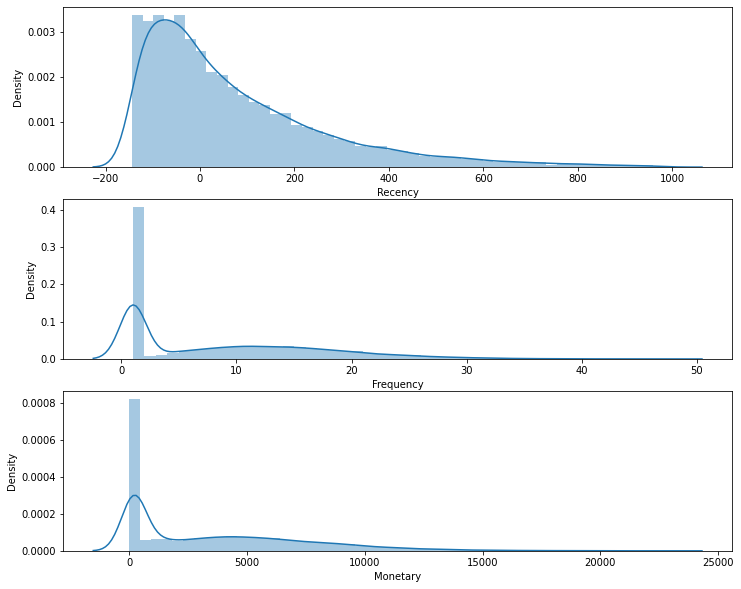

In [30]:
plt.figure(figsize=(12,10)) # Figure size
plt.subplot(3, 1, 1)
sns.distplot(Customer_seg['Recency'])# Plot distribution of R_Value
plt.subplot(3, 1, 2) 
sns.distplot(Customer_seg['Frequency'])# Plot distribution of F_Value
plt.subplot(3, 1, 3)
sns.distplot(Customer_seg['Monetary'])# Plot distribution of M_Value
plt.show()

In [31]:
quantiles = Customer_seg.quantile(q=[0.25,0.5,0.75]) #Dividing RFM data into four quartiles
quantiles = quantiles.to_dict() 

In [32]:
# R_Score should be minimum so 1st quantile is set as 1.
def Recency_Score(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]: 
        return 3
    else:
        return 4
# The higher the Frequency_Score, Monetary_Score the better so 1st quantile is set as 4.    
def Frequency_Score(x,y,z):
    if x <= z[y][0.25]:
        return 4
    elif x <= z[y][0.50]:
        return 3
    elif x <= z[y][0.75]: 
        return 2
    else:
        return 1

In [33]:
# New column for R_Score to indicate numerical score between 1 to 4.
Customer_seg['Recency_Score'] = Customer_seg['Recency'].apply(Recency_Score, args=('Recency',quantiles))
# New column for F_Score to indicate numerical score between 1 to 4.
Customer_seg['Frequency_Score'] = Customer_seg['Frequency'].apply(Frequency_Score, args=('Frequency',quantiles))
# New column for M_Score to indicate numerical score between 1 to 4.
Customer_seg['Monetary_Score'] = Customer_seg['Monetary'].apply(Frequency_Score, args=('Monetary',quantiles))
Customer_seg.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
Order Customer Id,,,,,,
1,648,1,2362.250061,4,4,3
2,-8,10,2842.700073,2,2,2
3,85,18,6143.760057,3,1,1
4,236,14,4370.629991,4,2,2
5,313,7,2993.790032,4,3,2


In [34]:
#Adding R,F,M Scores to one new column
Customer_seg['RFM_Score'] = Customer_seg.Recency_Score.astype(str)+ Customer_seg.Frequency_Score.astype(str) + Customer_seg.Monetary_Score.astype(str)
Customer_seg.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
Order Customer Id,,,,,,,
1,648,1,2362.250061,4,4,3,443
2,-8,10,2842.700073,2,2,2,222
3,85,18,6143.760057,3,1,1,311
4,236,14,4370.629991,4,2,2,422
5,313,7,2993.790032,4,3,2,432


In [35]:
count=Customer_seg['RFM_Score'].unique()
print(count)# Printing all Unique values
len(count)# Total count

['443' '222' '311' '422' '432' '421' '211' '322' '434' '212' '411' '331'
 '412' '433' '321' '423' '333' '312' '221' '223' '332' '233' '232' '323'
 '444' '431' '343' '243' '344' '334' '244' '143' '144']


33

In [36]:
Customer_seg['RFM_Total_Score'] = Customer_seg[['Recency_Score','Frequency_Score','Monetary_Score']].sum(axis=1)
Customer_seg['RFM_Total_Score'].unique()

array([11,  6,  5,  8,  9,  7,  4, 10, 12])

In [37]:
def RFM_Total_Score(df):

    if (df['RFM_Total_Score'] >= 11):# For RFM score with values 11,12
        return 'Champions' 
    elif (df['RFM_Total_Score'] == 10):# For RFM score with value 10
        return 'Loyal Customers' 
    elif (df['RFM_Total_Score'] == 9): # For RFM score with value 9
        return 'Recent Customers'
    elif (df['RFM_Total_Score'] == 8): # For RFM score with value 8
         return 'Promising'
    elif (df['RFM_Total_Score'] == 7): # For RFM score with value 7
        return 'Customers Needing Attention'
    elif (df['RFM_Total_Score'] == 6): # For RFM score with value 6
        return 'Cant lose them'
    elif (df['RFM_Total_Score'] == 5): # For RFM score with value 5
        return 'At Risk'
    else:                               # For RFM score with value less than 5
        
        return 'Lost'
# Create a new variable RFM_Level
Customer_seg['Customer_Segmentation'] =Customer_seg.apply(RFM_Total_Score, axis=1)
# Print the header with top 5 rows to the console
Customer_seg.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
1,648,1,2362.250061,4,4,3,443,11,Champions
2,-8,10,2842.700073,2,2,2,222,6,Cant lose them
3,85,18,6143.760057,3,1,1,311,5,At Risk
4,236,14,4370.629991,4,2,2,422,8,Promising
5,313,7,2993.790032,4,3,2,432,9,Recent Customers


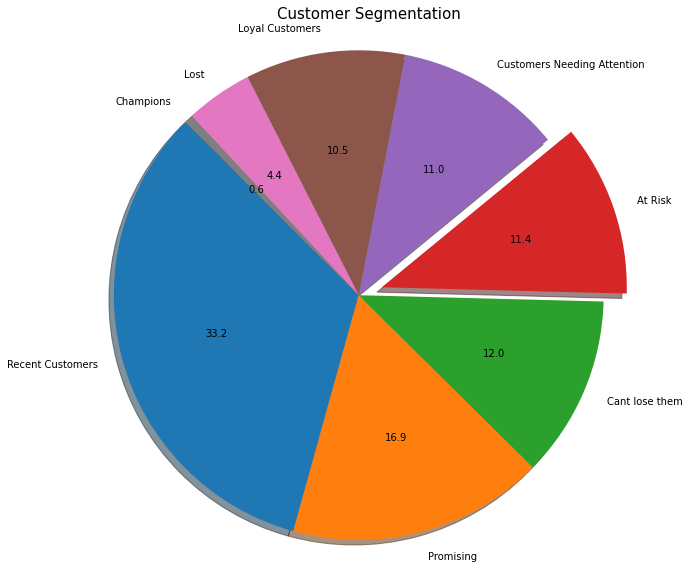

In [38]:
Customer_seg['Customer_Segmentation'].value_counts().plot.pie(figsize=(10,10),
                                        startangle=135, explode=(0,0,0,0.1,0,0,0,0),autopct='%.1f',shadow=True)
plt.title("Customer Segmentation",size=15)
plt.ylabel(" ")
plt.axis('equal') 
plt.show()

In [39]:
churned=Customer_seg[(Customer_seg['RFM_Score']=='411')].sort_values('Monetary', ascending=False).head(10)
churned

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
11065,165,41,18641.300091,4,1,1,411,6,Cant lose them
6285,188,37,18287.010097,4,1,1,411,6,Cant lose them
7892,248,29,17620.470196,4,1,1,411,6,Cant lose them
2893,168,24,17536.609842,4,1,1,411,6,Cant lose them
4181,281,29,17333.960094,4,1,1,411,6,Cant lose them
4781,358,31,17048.380088,4,1,1,411,6,Cant lose them
9271,200,35,17044.910217,4,1,1,411,6,Cant lose them
4659,273,27,16973.060024,4,1,1,411,6,Cant lose them
1695,182,33,16916.020176,4,1,1,411,6,Cant lose them


In [40]:
#The R_Score should be low and F_Score, M_Score should be as high as possible
Customer_seg[(Customer_seg['RFM_Score']=='144')|(Customer_seg['RFM_Score']=='143')].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
18101,-106,1,1500.0,1,4,3,143,8,Promising
18083,-105,1,1500.0,1,4,3,143,8,Promising
18047,-105,1,1500.0,1,4,3,143,8,Promising
18065,-105,1,1500.0,1,4,3,143,8,Promising
18119,-106,1,1500.0,1,4,3,143,8,Promising
18046,-105,1,1485.0,1,4,3,143,8,Promising
18100,-106,1,1485.0,1,4,3,143,8,Promising
18118,-106,1,1485.0,1,4,3,143,8,Promising
18064,-105,1,1485.0,1,4,3,143,8,Promising


# Data Modelling

In [41]:
train_data=data.copy()

In [42]:
train_data['fraud'] = np.where(train_data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_data['late_delivery']=np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)

In [43]:
train_data.drop(['Delivery Status','Late_delivery_risk','Order Status','order_month_year','order date (DateOrders)'], axis=1, inplace=True)

In [44]:
train_data.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Id                        int64
Customer Segment                  object
Customer State                    object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Market                            object
Order City                        object
Order Country                     object
Order Customer Id                  int64
Order Id                           int64
Order Item Cardprod Id             int64
Order Item Discount              float64
Order Item Discount Rate         float64
Order Item Id                      int64
Order Item Produ

In [45]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
train_data['Customer Country']  = le.fit_transform(train_data['Customer Country'])
train_data['Market']            = le.fit_transform(train_data['Market'])
train_data['Type']              = le.fit_transform(train_data['Type'])
train_data['Product Name']      = le.fit_transform(train_data['Product Name'])
train_data['Customer Segment']  = le.fit_transform(train_data['Customer Segment'])
train_data['Customer State']    = le.fit_transform(train_data['Customer State'])
train_data['Order Region']      = le.fit_transform(train_data['Order Region'])
train_data['Order City']        = le.fit_transform(train_data['Order City'])
train_data['Category Name']     = le.fit_transform(train_data['Category Name'])
train_data['Customer City']     = le.fit_transform(train_data['Customer City'])
train_data['Department Name']   = le.fit_transform(train_data['Department Name'])
train_data['Order State']       = le.fit_transform(train_data['Order State'])
train_data['Shipping Mode']     = le.fit_transform(train_data['Shipping Mode'])
train_data['order_week_day']    = le.fit_transform(train_data['order_week_day'])
train_data['Order Country']     = le.fit_transform(train_data['Order Country'])
train_data['Customer Full Name']= le.fit_transform(train_data['Customer Full Name'])

#display the initial records
train_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Category Name,Customer City,Customer Country,Customer Id,...,Product Price,Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,TotalPrice,fraud,late_delivery
0,1,3,4,91.250000,314.640015,73,40,66,1,20755,...,327.75,3,1876,2018,1,2,22,314.640015,0,0
1,3,5,4,-249.089996,311.359985,73,40,66,1,19492,...,327.75,3,5378,2018,1,5,12,311.359985,0,1
2,0,4,4,-247.779999,309.720001,73,40,452,0,19491,...,327.75,3,4429,2018,1,5,12,309.720001,0,0
3,1,3,4,22.860001,304.809998,73,40,285,0,19490,...,327.75,3,12929,2018,1,5,11,304.809998,0,0
4,2,2,4,134.210007,298.250000,73,40,66,1,19489,...,327.75,3,10638,2018,1,5,11,298.250000,0,0


# Comparision of Classification Models

In [46]:
#All columns expect fraud
xf = train_data.loc[:, train_data.columns != 'fraud']
#Only fraud column
yf = train_data['fraud']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xf_train, xf_test,yf_train,yf_test = train_test_split(xf,yf,test_size = 0.2,random_state = 42)
#All columns expect fraud
xl=train_data.loc[:, train_data.columns != 'late_delivery']
#Only fraud column
yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xl_train, xl_test,yl_train,yl_test = train_test_split(xl,yl,test_size = 0.2, random_state = 42)

In [47]:
sc = StandardScaler()
xf_train=sc.fit_transform(xf_train)
xf_test=sc.transform(xf_test)
xl_train=sc.fit_transform(xl_train)
xl_test=sc.transform(xl_test)

In [48]:
def classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test):
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery

    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)  

    accuracy_f=accuracy_score(yf_pred, yf_test) #Accuracy for fraud detection
    accuracy_l=accuracy_score(yl_pred, yl_test) #Accuracy for predection of late delivery

    recall_f=recall_score(yf_pred, yf_test) #Recall score for  fraud detection
    recall_l=recall_score(yl_pred, yl_test)# Recall score for predection of late delivery

    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

    f1_f=f1_score(yf_test, yf_pred)#fraud detection
    f1_l=f1_score(yl_test, yl_pred)#predection of late delivery
    
    print('Model paramters used are :',model_f)
    print('Accuracy of fraud status is        :', (accuracy_f)*100,'%')
    print('Recall score of fraud status is        :', (recall_f)*100,'%')
    print('Conf Matrix of fraud status is        :\n',  (conf_f))
    print('F1 score of fraud status is        :', (f1_f)*100,'%')
    print('Accuracy of late delivery status is:', (accuracy_l)*100,'%')
    print('Recall score of late delivery status is:', (recall_l)*100,'%')
    print('Conf Matrix of late delivery status is: \n',(conf_l))
    print('F1 score of late delivery status is:', (f1_l)*100,'%')

# Logistic Regression classification model

In [49]:
model_f = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
model_l = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
#Giving inputs to the defined function
classifiermodel(model_f, model_l, xf_train, xf_test, yf_train, yf_test, xl_train, xl_test, yl_train, yl_test)

Model paramters used are : LogisticRegression(random_state=0)
Accuracy of fraud status is        : 97.79248836693995 %
Recall score of fraud status is        : 58.307210031347964 %
Conf Matrix of fraud status is        :
 [[35121   133]
 [  664   186]]
F1 score of fraud status is        : 31.822070145423435 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


# Gaussian naive bayes model

In [50]:
model_f = GaussianNB()
model_l = GaussianNB()
classifiermodel(model_f, model_l, xf_train, xf_test, yf_train, yf_test, xl_train, xl_test, yl_train, yl_test)

Model paramters used are : GaussianNB()
Accuracy of fraud status is        : 87.84899180146243 %
Recall score of fraud status is        : 16.23066641206798 %
Conf Matrix of fraud status is        :
 [[30867  4387]
 [    0   850]]
F1 score of fraud status is        : 27.928371940200424 %
Accuracy of late delivery status is: 57.26789275426546 %
Recall score of late delivery status is: 56.20261790510804 %
Conf Matrix of late delivery status is: 
 [[  882 15425]
 [    3 19794]]
F1 score of late delivery status is: 71.957248800349 %


# Support vector machines

In [51]:
model_f = svm.LinearSVC()
model_l = svm.LinearSVC()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : LinearSVC()
Accuracy of fraud status is        : 97.76479060491913 %
Recall score of fraud status is        : 57.43944636678201 %
Conf Matrix of fraud status is        :
 [[35131   123]
 [  684   166]]
F1 score of fraud status is        : 29.148375768217733 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


# K nearest Neighbors classification

In [52]:
model_f = KNeighborsClassifier(n_neighbors=1)
model_l = KNeighborsClassifier(n_neighbors=1)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : KNeighborsClassifier(n_neighbors=1)
Accuracy of fraud status is        : 97.38810104143585 %
Recall score of fraud status is        : 42.72300469483568 %
Conf Matrix of fraud status is        :
 [[34888   366]
 [  577   273]]
F1 score of fraud status is        : 36.66890530557421 %
Accuracy of late delivery status is: 80.35674717482827 %
Recall score of late delivery status is: 82.9025741958875 %
Conf Matrix of late delivery status is: 
 [[13006  3301]
 [ 3791 16006]]
F1 score of late delivery status is: 81.86374795417349 %


# Random forest classification

In [53]:
model_f = RandomForestClassifier()
model_l = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : RandomForestClassifier()
Accuracy of fraud status is        : 98.70097496122312 %
Recall score of fraud status is        : 97.03703703703704 %
Conf Matrix of fraud status is        :
 [[35242    12]
 [  457   393]]
F1 score of fraud status is        : 62.62948207171314 %
Accuracy of late delivery status is: 98.23842233547529 %
Recall score of late delivery status is: 96.88738804874468 %
Conf Matrix of late delivery status is: 
 [[15671   636]
 [    0 19797]]
F1 score of late delivery status is: 98.41909023117077 %


# XG Boost Classification

In [55]:
model_f = xgb.XGBClassifier()
model_l = xgb.XGBClassifier()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : XGBClassifier()
Accuracy of fraud status is        : 97.76756038112121 %
Recall score of fraud status is        : 61.458333333333336 %
Conf Matrix of fraud status is        :
 [[35180    74]
 [  732   118]]
F1 score of fraud status is        : 22.648752399232247 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


# Decision tree classification

In [56]:
model_f = tree.DecisionTreeClassifier()
model_l = tree.DecisionTreeClassifier()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

Model paramters used are : DecisionTreeClassifier()
Accuracy of fraud status is        : 99.03888765787724 %
Recall score of fraud status is        : 79.9761620977354 %
Conf Matrix of fraud status is        :
 [[35086   168]
 [  179   671]]
F1 score of fraud status is        : 79.45529899348726 %
Accuracy of late delivery status is: 99.34356304010636 %
Recall score of late delivery status is: 99.40391998383512 %
Conf Matrix of late delivery status is: 
 [[16189   118]
 [  119 19678]]
F1 score of late delivery status is: 99.40140934003486 %


In [57]:
#Giving column Values
classification_data = {'Classification Model':  ['Logistic','Gausian Naive bayes','Support Vector Machines','K nearest Neighbour',
                                'Linear Discriminant Analysis','Random Forest','Extra trees','eExtreme gradient boosting','Decision tree'],
        'Accuracy Score for Fraud Detection':     [97.80,87.84,97.75,97.36,97.88,98.48,98.61,98.93,99.12],
        'Recall Score for Fraud Detection':       [59.40,16.23,56.89,41.90,56.57,93.18,98.88,89.89,82.53],
        'F1 Score for Fraud Detection':           [31.22,27.92,28.42,35.67,49.20,54.57,58.60,73.22,81.00],
        'Accuracy Score for Late Delivery':       [98.84,57.27,98.84,80.82,98.37,98.60,99.17,99.24,99.37],
        'Recall Score for Late Delivery':         [97.94,56.20,97.94,83.45,97.68,97.52,98.51,98.65,99.44],
        'F1 Score for Late Delivery':             [98.96,71.95,98.96,82.26,98.52,98.74,99.25,99.31,99.42] }
#Creating data frame with Column Names
classification_comparision = pd.DataFrame (classification_data, columns = ['Classification Model','Accuracy Score for Fraud Detection','Recall Score for Fraud Detection','F1 Score for Fraud Detection',
                                                                           'Accuracy Score for Late Delivery','Recall Score for Late Delivery','F1 Score for Late Delivery'])

# Comparision Table for Classification Scores

In [58]:
classification_comparision

,Classification Model,Accuracy Score for Fraud Detection,Recall Score for Fraud Detection,F1 Score for Fraud Detection,Accuracy Score for Late Delivery,Recall Score for Late Delivery,F1 Score for Late Delivery
0,Logistic,97.80,59.40,31.22,98.84,97.94,98.96
1,Gausian Naive bayes,87.84,16.23,27.92,57.27,56.20,71.95
2,Support Vector Machines,97.75,56.89,28.42,98.84,97.94,98.96
3,K nearest Neighbour,97.36,41.90,35.67,80.82,83.45,82.26
4,Linear Discriminant Analysis,97.88,56.57,49.20,98.37,97.68,98.52
5,Random Forest,98.48,93.18,54.57,98.60,97.52,98.74
6,Extra trees,98.61,98.88,58.60,99.17,98.51,99.25
7,eExtreme gradient boosting,98.93,89.89,73.22,99.24,98.65,99.31
8,Decision tree,99.12,82.53,81.00,99.37,99.44,99.42


In [59]:
classification_comparision.max()

Classification Model                  eExtreme gradient boosting
Accuracy Score for Fraud Detection                         99.12
Recall Score for Fraud Detection                           98.88
F1 Score for Fraud Detection                                81.0
Accuracy Score for Late Delivery                           99.37
Recall Score for Late Delivery                             99.44
F1 Score for Late Delivery                                 99.42
dtype: object

In [60]:
def cross_validation_model(model_f,model_l,xf,yf,xl,yl):
    model_f= model_f.fit(xf,yf)
    model_l = model_l.fit(xl,yl)

    scores_f = cross_val_score(model_f, xf, yf, cv=6)
    scores_l = cross_val_score(model_l, xl, yl, cv=6)

    print('Model used is', model_f)
    print('Cross validation accuracy of fraud: %0.2f (+/- %0.2f)' % (scores_f.mean(), scores_f.std() * 2))
    print('Cross validation accuracy of late : %0.2f (+/- %0.2f)' % (scores_l.mean(), scores_l.std() * 2))

In [61]:
cross_validation_model(model_f, model_l, xf, yf, xl, yl)

Model used is DecisionTreeClassifier()
Cross validation accuracy of fraud: 0.96 (+/- 0.04)
Cross validation accuracy of late : 0.98 (+/- 0.02)


# Feature Importance

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text major ticklabel objects>)

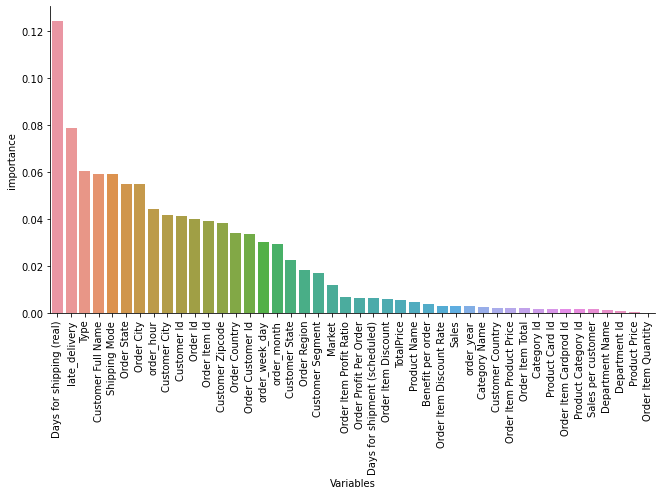

In [62]:
important_col=model_f.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':xf.columns[important_col],'importance':model_f.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text major ticklabel objects>)

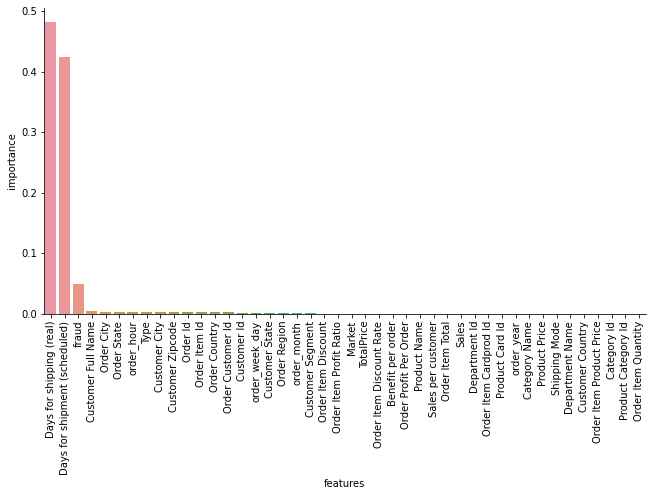

In [63]:
important_col=model_l.feature_importances_.argsort()
feat_imp=pd.DataFrame({'features':xl.columns[important_col], 'importance':model_l.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance', ascending=False)
ax = sns.catplot(x='features', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

In [64]:
new_data=train_data.copy()

In [65]:
new_data=new_data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1)

In [66]:
new_xl=new_data.loc[:, new_data.columns != 'late_delivery']
#Only fraud column
new_yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
new_xl_train, new_xl_test, new_yl_train, new_yl_test = train_test_split(new_xl, new_yl,test_size = 0.2, random_state = 42)

In [67]:
new_xl_train=sc.fit_transform(new_xl_train)
new_xl_test=sc.transform(new_xl_test)

In [68]:
def New_classifiermodel(model_c,xc_train, xc_test,yc_train,yc_test):
    model_c = model_c.fit(xc_train,yc_train)
    yc_pred = model_c.predict(xc_test) 
    accuracy_c = accuracy_score(yc_pred, yc_test)
    recall_c = recall_score(yc_pred, yc_test, average = 'weighted')
    conf_c = confusion_matrix(yc_test, yc_pred)
    f1_c = f1_score(yc_test, yc_pred, average = 'weighted')
    print('Model paramters used are :', model_c)
    print('Accuracy         :', (accuracy_c)*100,'%')
    print('Recall score        :', (recall_c)*100,'%')
    print('Conf Matrix        : \n',(conf_c))
    print('F1 score       :', (f1_c)*100,'%')

In [69]:
new_model_l = tree.DecisionTreeClassifier()
New_classifiermodel(new_model_l, new_xl_train, new_xl_test, new_yl_train, new_yl_test)

Model paramters used are : DecisionTreeClassifier()
Accuracy         : 83.522601373809 %
Recall score        : 83.522601373809 %
Conf Matrix        : 
 [[13285  3022]
 [ 2927 16870]]
F1 score       : 83.51825332835935 %


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

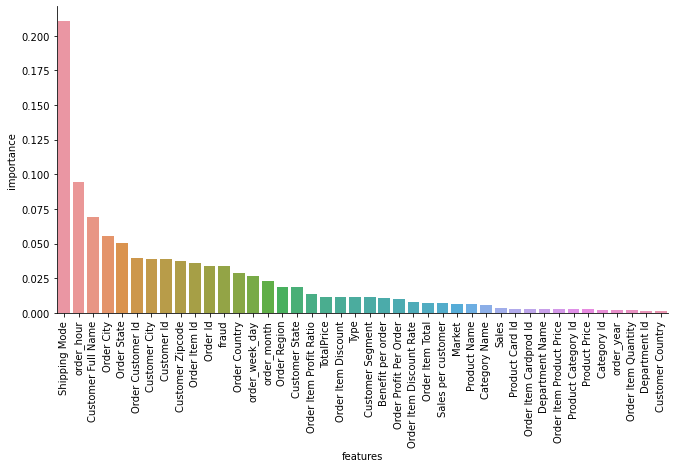

In [70]:
important_col = new_model_l.feature_importances_.argsort()
feat_imp = pd.DataFrame({'features':new_xl.columns[important_col],'importance':new_model_l.feature_importances_[important_col]})
feat_imp = feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='features', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

In [71]:
#All columns expect order country
xc=train_data.loc[:, train_data.columns != 'Order Country']
#Order column country
yc=train_data['Order Country']
#Splitting 20% of dataset as test data 
xc_train, xc_test,yc_train,yc_test = train_test_split(xc,yc,test_size = 0.2, random_state = 42)

In [72]:
xc_train = sc.fit_transform(xc_train)
xc_test=sc.transform(xc_test)

In [73]:
model_c=tree.DecisionTreeClassifier()
New_classifiermodel(model_c,xc_train, xc_test,yc_train,yc_test)

Model paramters used are : DecisionTreeClassifier()
Accuracy         : 99.79226678484379 %
Recall score        : 99.79226678484379 %
Conf Matrix        : 
 [[  38    0    0 ...    0    0    0]
 [   0    7    0 ...    0    0    0]
 [   0    0 1930 ...    0    0    0]
 ...
 [   0    0    0 ...    4    0    0]
 [   0    0    0 ...    0   45    0]
 [   0    0    0 ...    0    0   47]]
F1 score       : 99.79353798853543 %


# Neural Network Model for Classification

In [74]:
keras.layers.BatchNormalization()
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(1024, activation='relu',kernel_initializer='random_normal', input_dim=44)) #Since we have 44 columns
#Third Hidden Layer
classifier.add(Dense(512, activation='relu',kernel_initializer='random_normal'))
#Fourth Hidden Layer
classifier.add(Dense(256, activation='relu',kernel_initializer='random_normal'))
#Fifth Hidden Layer
classifier.add(Dense(128, activation='relu',kernel_initializer='random_normal'))
#Sixth Hidden Layer
classifier.add(Dense(64, activation='relu',kernel_initializer='random_normal'))
#Seventh Hidden Layer
classifier.add(Dense(32, activation='relu',kernel_initializer='random_normal'))
#Eight Hidden Layer
classifier.add(Dense(16, activation='relu',kernel_initializer='random_normal'))
#Ninth Hidden Layer
classifier.add(Dense(8, activation='relu',kernel_initializer='random_normal'))
#Tenth Hidden Layer
classifier.add(Dense(4, activation='relu',kernel_initializer='random_normal'))
#Eleventh Hidden Layer
classifier.add(Dense(2, activation='relu',kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid',kernel_initializer='random_normal'))

In [75]:
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [76]:
classifier.fit(xf_train,yf_train, batch_size=512, epochs=10)

Epoch 1/10
283/283 [==============================] - 17s 55ms/step - loss: 0.2218 - accuracy: 0.9778
Epoch 2/10
283/283 [==============================] - 16s 55ms/step - loss: 0.0541 - accuracy: 0.9778
Epoch 3/10
283/283 [==============================] - 16s 55ms/step - loss: 0.0517 - accuracy: 0.9778
Epoch 4/10
283/283 [==============================] - 17s 59ms/step - loss: 0.0498 - accuracy: 0.9778
Epoch 5/10
283/283 [==============================] - 15s 53ms/step - loss: 0.0484 - accuracy: 0.9778
Epoch 6/10
283/283 [==============================] - 15s 54ms/step - loss: 0.0472 - accuracy: 0.9778
Epoch 7/10
283/283 [==============================] - 15s 54ms/step - loss: 0.0455 - accuracy: 0.9778
Epoch 8/10
283/283 [==============================] - 15s 54ms/step - loss: 0.0437 - accuracy: 0.9778
Epoch 9/10
283/283 [==============================] - 15s 55ms/step - loss: 0.0420 - accuracy: 0.9778
Epoch 10/10
283/283 [==============================] - 15s 54ms/step - loss: 0.038

# Comparision of Regression Models

In [77]:
xs=train_data.loc[:, train_data.columns != 'Sales']
ys=train_data['Sales']
xs_train, xs_test,ys_train,ys_test = train_test_split(xs,ys,test_size = 0.3, random_state = 42)
xq=train_data.loc[:, train_data.columns != 'Order Item Quantity']
yq=train_data['Order Item Quantity']
xq_train, xq_test,yq_train,yq_test = train_test_split(xq,yq,test_size = 0.3, random_state = 42)

In [78]:
scaler=MinMaxScaler()
xs_train=scaler.fit_transform(xs_train)
xs_test=scaler.transform(xs_test)
xq_train=scaler.fit_transform(xq_train)
xq_test=scaler.transform(xq_test)

The data is now ready to be used in machine learning models.Since, different models are compared here like above a function is defined. The output is regression type so accuracy cannot be used as a measure to compare different models like classification models, so all the models are compared using mean absolute error (MAE) and RMSE.

The lower the value of mean absolute error the better the model is performing and lower values of RMSE indicate better fit.

In [79]:
def regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test):
    model_s=model_s.fit(xs_train,ys_train)#Fitting train data for sales
    model_q=model_q.fit(xq_train,yq_train)#Fitting train data for order quantity
    ys_pred=model_s.predict(xs_test)#predicting sales with test data
    yq_pred=model_q.predict(xq_test)#predicting order quantity with test data
    print('Model parameter used are:',model_s) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    print("MAE of sales is         :", metrics.mean_absolute_error(ys_test,ys_pred))
    #Printing Root mean squared error for predicting sales
    print("RMSE of sales is        :",np.sqrt(metrics.mean_squared_error(ys_test,ys_pred)))
    #Printing mean absolute error for predicting order quantity
    print("MAE of order quantity   :", metrics.mean_absolute_error(yq_test,yq_pred))
    #Printing Root mean squared error for predicting order quantity
    print("RMSE of order quantity  :",np.sqrt(metrics.mean_squared_error(yq_test,yq_pred)))

In [80]:
model_s = linear_model.Lasso(alpha=0.1)
model_q = linear_model.Lasso(alpha=0.1)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: Lasso(alpha=0.1)
MAE of sales is         : 1.5543249732525921
RMSE of sales is        : 2.3330668537282264
MAE of order quantity   : 0.9045863703745013
RMSE of order quantity  : 1.0305321636898375


In [81]:
model_s = Ridge(alpha=1.0)
model_q = Ridge(alpha=1.0)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)


Model parameter used are: Ridge()
MAE of sales is         : 0.7550980275645373
RMSE of sales is        : 0.9797923327190609
MAE of order quantity   : 0.34598281200905096
RMSE of order quantity  : 0.5221095120349866


In [82]:
model_s = lgb.LGBMRegressor()
model_q = lgb.LGBMRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: LGBMRegressor()
MAE of sales is         : 0.4608967314236202
RMSE of sales is        : 1.6694322183572285
MAE of order quantity   : 0.0015026406737609238
RMSE of order quantity  : 0.01083017104892248


##Random Forest Regression

In [83]:
model_s = RandomForestRegressor(n_estimators=100,max_depth=10, random_state=40)
model_q = RandomForestRegressor(n_estimators=100,max_depth=10, random_state=40)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: RandomForestRegressor(max_depth=10, random_state=40)
MAE of sales is         : 0.19170857280830786
RMSE of sales is        : 1.882911557250712
MAE of order quantity   : 0.00011910028905403445
RMSE of order quantity  : 0.006147288482544812


In [84]:
model_s = xgb.XGBRegressor()
model_q = xgb.XGBRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

[19:51:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model parameter used are: XGBRegressor()
MAE of sales is         : 1.7835266228264823
RMSE of sales is        : 3.953767965247966
MAE of order quantity   : 0.024706041038507407
RMSE of order quantity  : 0.05133089126585871


In [85]:
model_s = tree.DecisionTreeRegressor()
model_q = tree.DecisionTreeRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: DecisionTreeRegressor()
MAE of sales is         : 0.013110459433983574
RMSE of sales is        : 0.8649468450090139
MAE of order quantity   : 3.6930349361104953e-05
RMSE of order quantity  : 0.006077034586136972


In [86]:
model_s=LinearRegression()
model_q=LinearRegression()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: LinearRegression()
MAE of sales is         : 0.0005995640728439641
RMSE of sales is        : 0.001478329241598482
MAE of order quantity   : 0.3420250632841426
RMSE of order quantity  : 0.5215434813001418


In [87]:
#Giving column Values
Regression_data = {'Regression Model':  ['Lasso','Ridge','Light Gradient Boosting','Random Forest',
                                 'eXtreme gradient boosting','Decision tree','Linear Regression'],
        'MAE Value for Sales' :        [1.55,0.75,0.46,0.19,0.154,0.013,0.0005],
        'RMSE Value for Sales':        [2.33,0.97,1.66,1.79,3.13,0.918,0.0014],
        'MAE Value for Quantity' :     [0.90,0.34,0.001,0.0001,0.0005,3.69,0.34],
        'RMSE Value for Quantity':     [1.03,0.52,0.011,0.006,0.004,0.006,0.52] }
#Creating data frame with Column Names
Regression_comparision = pd.DataFrame (Regression_data, columns = ['Regression Model','MAE Value for Sales','RMSE Value for Sales',
        'MAE Value for Quantity','RMSE Value for Quantity'])

In [88]:
Regression_comparision

,Regression Model,MAE Value for Sales,RMSE Value for Sales,MAE Value for Quantity,RMSE Value for Quantity
0,Lasso,1.5500,2.3300,0.9000,1.030
1,Ridge,0.7500,0.9700,0.3400,0.520
2,Light Gradient Boosting,0.4600,1.6600,0.0010,0.011
3,Random Forest,0.1900,1.7900,0.0001,0.006
4,eXtreme gradient boosting,0.1540,3.1300,0.0005,0.004
5,Decision tree,0.0130,0.9180,3.6900,0.006
6,Linear Regression,0.0005,0.0014,0.3400,0.520


In [89]:
Regression_comparision.min()

Regression Model           Decision tree
MAE Value for Sales               0.0005
RMSE Value for Sales              0.0014
MAE Value for Quantity            0.0001
RMSE Value for Quantity            0.004
dtype: object

# Neural Network Model for Regression

In [90]:
regressor = Sequential()

#First Hidden Layer
regressor.add(Dense(512, activation='relu',kernel_initializer='normal',input_dim=44))
#Second  Hidden Layer
regressor.add(Dense(256, activation='relu',kernel_initializer='normal'))
#Third  Hidden Layer
regressor.add(Dense(256, activation='relu',kernel_initializer='normal'))
#Fourth  Hidden Layer
regressor.add(Dense(256, activation='relu',kernel_initializer='normal'))
#Fifth  Hidden Layer
regressor.add(Dense(256, activation='relu',kernel_initializer='normal'))

#Output Layer
regressor.add(Dense(1, activation='linear'))# Linear activation is used. 

In [91]:
regressor.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mean_absolute_error'])

In [92]:
regressor.fit(xq_train, yq_train, batch_size=256, epochs=10)

Epoch 1/10
494/494 [==============================] - 9s 17ms/step - loss: 0.2466 - mean_absolute_error: 0.2466
Epoch 2/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0812 - mean_absolute_error: 0.0812
Epoch 3/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0690 - mean_absolute_error: 0.0690
Epoch 4/10
494/494 [==============================] - 8s 17ms/step - loss: 0.0584 - mean_absolute_error: 0.0584
Epoch 5/10
494/494 [==============================] - 8s 17ms/step - loss: 0.0484 - mean_absolute_error: 0.0484
Epoch 6/10
494/494 [==============================] - 8s 17ms/step - loss: 0.0414 - mean_absolute_error: 0.0414
Epoch 7/10
494/494 [==============================] - 8s 17ms/step - loss: 0.0386 - mean_absolute_error: 0.0386
Epoch 8/10
494/494 [==============================] - 8s 17ms/step - loss: 0.0346 - mean_absolute_error: 0.0346
Epoch 9/10
494/494 [==============================] - 8s 17ms/step - loss: 0.0319 - mean_absolute_error:

In [93]:
regressor.fit(xq_train,yq_train, batch_size=256, epochs=50)

Epoch 1/50
494/494 [==============================] - 8s 17ms/step - loss: 0.0285 - mean_absolute_error: 0.0285
Epoch 2/50
494/494 [==============================] - 8s 17ms/step - loss: 0.0279 - mean_absolute_error: 0.0279
Epoch 3/50
494/494 [==============================] - 8s 17ms/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 4/50
494/494 [==============================] - 8s 16ms/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 5/50
494/494 [==============================] - 10s 19ms/step - loss: 0.0225 - mean_absolute_error: 0.0225
Epoch 6/50
494/494 [==============================] - 8s 17ms/step - loss: 0.0232 - mean_absolute_error: 0.0232
Epoch 7/50
494/494 [==============================] - 8s 17ms/step - loss: 0.0216 - mean_absolute_error: 0.0216
Epoch 8/50
494/494 [==============================] - 8s 17ms/step - loss: 0.0195 - mean_absolute_error: 0.0195
Epoch 9/50
494/494 [==============================] - 8s 17ms/step - loss: 0.0185 - mean_absolute_error

In [94]:
pred_train_q= regressor.predict(xq_train)
pred_q_test= regressor.predict(xq_test)
print('MAE Value train data:',regressor.evaluate(xq_train,yq_train))
print('RMSE of train data:',np.sqrt(mean_squared_error(yq_train,pred_train_q)))
print('MAE Value test data:',regressor.evaluate(xq_test,yq_test))
print('RMSE of test data:',np.sqrt(mean_squared_error(yq_test,pred_q_test)))

3949/3949 [==============================] - 11s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0055
MAE Value train data: [0.005459832958877087, 0.005459832958877087]
RMSE of train data: 0.01476284997022163
1693/1693 [==============================] - 4s 2ms/step - loss: 0.0055 - mean_absolute_error: 0.0055
MAE Value test data: [0.005455274134874344, 0.005455274134874344]
RMSE of test data: 0.015786617213769866
